In [5]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn import decomposition
from scipy import linalg
import matplotlib.pyplot as plt

In [6]:
%matplotlib inline
np.set_printoptions(suppress=True)

In [7]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
remove = ('headers', 'footers', 'quotes')
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories, remove=remove)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories, remove=remove)

In [8]:
newsgroups_train.filenames.shape, newsgroups_train.target.shape

((2034,), (2034,))

In [9]:
print("\n".join(newsgroups_train.data[:3]))

Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych


Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been demonstrating such evil corruption
for centuries.

 >In article <1993Apr19.020359.26996@sq.sq.com>, msb@sq.sq.c

In [10]:
np.array(newsgroups_train.target_names)[newsgroups_train.target[:3]]

array(['comp.graphics', 'talk.religion.misc', 'sci.space'], dtype='<U18')

In [11]:
newsgroups_train.target[:10]

array([1, 3, 2, 0, 2, 0, 2, 1, 2, 1])

In [12]:
num_topics, num_top_words = 6, 8

In [13]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [14]:
vectorizer = CountVectorizer(stop_words='english')
vectors = vectorizer.fit_transform(newsgroups_train.data).todense() # (documents, vocab)
vectors.shape #, vectors.nnz / vectors.shape[0], row_means.shape

(2034, 26576)

In [15]:
print(len(newsgroups_train.data), vectors.shape)

2034 (2034, 26576)


In [16]:
vocab = np.array(vectorizer.get_feature_names())

In [17]:
vocab.shape

(26576,)

In [18]:
vocab[7000:7020]

array(['cosmonauts', 'cosmos', 'cosponsored', 'cost', 'costa', 'costar',
       'costing', 'costly', 'costruction', 'costs', 'cosy', 'cote',
       'couched', 'couldn', 'council', 'councils', 'counsel',
       'counselees', 'counselor', 'count'], dtype='<U80')

In [19]:
%time U, s, Vh = linalg.svd(vectors, full_matrices=False)

CPU times: user 41.2 s, sys: 1.2 s, total: 42.4 s
Wall time: 12.2 s


In [20]:
print(U.shape, s.shape, Vh.shape)

(2034, 2034) (2034,) (2034, 26576)


In [21]:
#Exercise: confrim that U, s, Vh is a decomposition of the var Vectors
reconstructed_vectors = U @ np.diag(s) @ Vh
np.linalg.norm(reconstructed_vectors - vectors)
np.allclose(reconstructed_vectors, vectors)

True

In [22]:
#Exercise: Confirm that U, Vh are orthonormal
np.allclose(U.T @ U, np.eye(U.shape[0]))
np.allclose(Vh @ Vh.T, np.eye(Vh.shape[0]))

True

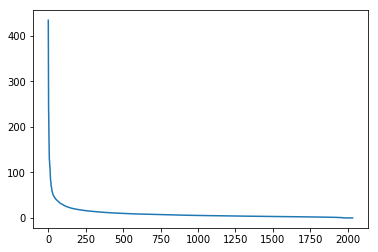

In [23]:
# What can we say about the singular values s?
plt.plot(s)

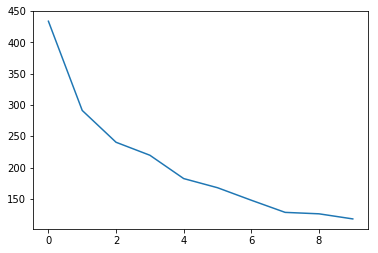

In [24]:
plt.plot(s[:10])

In [25]:
num_top_words=8

def show_topics(a):
    top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_top_words-1:-1]]
    topic_words = ([top_words(t) for t in a])
    return [' '.join(t) for t in topic_words]

In [26]:
show_topics(Vh[:10])

['ditto critus propagandist surname galacticentric kindergarten surreal imaginative',
 'jpeg gif file color quality image jfif format',
 'graphics edu pub mail 128 3d ray ftp',
 'jesus god matthew people atheists atheism does graphics',
 'image data processing analysis software available tools display',
 'god atheists atheism religious believe religion argument true',
 'space nasa lunar mars probe moon missions probes',
 'image probe surface lunar mars probes moon orbit',
 'argument fallacy conclusion example true ad argumentum premises',
 'space larson image theory universe physical nasa material']

In [27]:
# Non-negative Matrix Factorization (NMF) e.g. face decomposition, collaborative filtering, topic modeling
m,n=vectors.shape
d=5  # num topics

In [28]:
clf = decomposition.NMF(n_components=d, random_state=1)

W1 = clf.fit_transform(vectors)
H1 = clf.components_

In [29]:
show_topics(H1)

['jpeg image gif file color images format quality',
 'edu graphics pub mail 128 ray ftp send',
 'space launch satellite nasa commercial satellites year market',
 'jesus god people matthew atheists does atheism said',
 'image data available software processing ftp edu analysis']

In [30]:
# TF-IDF
vectorizer_tfidf = TfidfVectorizer(stop_words='english')
vectors_tfidf = vectorizer_tfidf.fit_transform(newsgroups_train.data) # (documents, vocab)

In [31]:
W1 = clf.fit_transform(vectors_tfidf)
H1 = clf.components_

In [32]:
show_topics(H1)

['people don think just like objective say morality',
 'graphics thanks files image file program windows know',
 'space nasa launch shuttle orbit moon lunar earth',
 'ico bobbe tek beauchaine bronx manhattan sank queens',
 'god jesus bible believe christian atheism does belief']

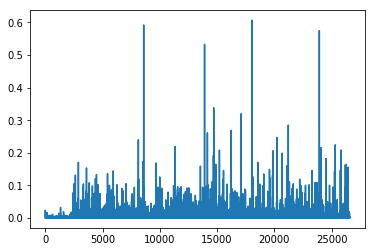

In [33]:
plt.plot(clf.components_[0])

In [34]:
clf.reconstruction_err_

43.71292605795277

In [35]:
# Applying SGD to NMF
lam=1e3
lr=1e-2
m, n = vectors_tfidf.shape

In [36]:
W1 = clf.fit_transform(vectors)
H1 = clf.components_

In [37]:
show_topics(H1)

['jpeg image gif file color images format quality',
 'edu graphics pub mail 128 ray ftp send',
 'space launch satellite nasa commercial satellites year market',
 'jesus god people matthew atheists does atheism said',
 'image data available software processing ftp edu analysis']

In [38]:
mu = 1e-6
def grads(M, W, H):
    R = W@H-M
    return R@H.T + penalty(W, mu)*lam, W.T@R + penalty(H, mu)*lam # dW, dH

In [39]:
# penalize matrices, W and H, when they are negative
def penalty(M, mu):
    return np.where(M>=mu,0, np.min(M - mu, 0))

In [40]:
def upd(M, W, H, lr):
    dW,dH = grads(M,W,H)
    W -= lr*dW; H -= lr*dH

In [41]:
def report(M,W,H): 
    print(np.linalg.norm(M-W@H), W.min(), H.min(), (W<0).sum(), (H<0).sum())

In [42]:
W = np.abs(np.random.normal(scale=0.01, size=(m,d)))
H = np.abs(np.random.normal(scale=0.01, size=(d,n)))

In [43]:
report(vectors_tfidf, W, H)

44.42590690358817 4.402057197643792e-07 5.3340900045231135e-09 0 0


In [44]:
upd(vectors_tfidf,W,H,lr)

In [45]:
report(vectors_tfidf, W, H)

44.41799741370005 -0.0008952350621225772 -8.636300670015086e-05 152 299


In [46]:
for i in range(50): 
    upd(vectors_tfidf,W,H,lr)
    if i % 10 == 0: report(vectors_tfidf,W,H)

44.41240327991719 -0.0008107143501328698 -5.946201874863327e-05 148 269
44.373643695930646 -0.0003099515468454275 -5.9450139448350174e-05 33 474
44.344369401531154 -0.00018604664712829953 -6.030023279414204e-05 26 1060
44.31196394765934 -0.00012541782003166958 -8.449057903612989e-05 22 1507
44.276585396937634 -7.56353382951287e-05 -0.0001294115986567931 28 2350


In [47]:
show_topics(H)

['space people god don just think like does',
 'space god just don people know think like',
 'space people don god just think know like',
 'space think just don people like know god',
 'god don people space like think know just']

In [58]:
#PyTorch
import torch
from torch.autograd import Variable

In [59]:
def V(M): return Variable(M, requires_grad=True)

In [60]:
v=vectors_tfidf.todense()

In [61]:
t_vectors = torch.Tensor(v.astype(np.float32))

In [62]:
mu = 1e-5

In [63]:
def grads_t(M, W, H):
    R = W.mm(H)-M
    return (R.mm(H.t()) + penalty_t(W, mu)*lam, 
        W.t().mm(R) + penalty_t(H, mu)*lam) # dW, dH

def penalty_t(M, mu):
    return (M<mu).type(tc.FloatTensor)*torch.clamp(M - mu, max=0.)

def upd_t(M, W, H, lr):
    dW,dH = grads_t(M,W,H)
    W.sub_(lr*dW); H.sub_(lr*dH)

def report_t(M,W,H): 
    print((M-W.mm(H)).norm(2), W.min(), H.min(), (W<0).sum(), (H<0).sum())

In [64]:
t_W = torch.FloatTensor(m,d)
t_H = torch.FloatTensor(d,n)
t_W.normal_(std=0.01).abs_(); 
t_H.normal_(std=0.01).abs_();

In [65]:
d=6; lam=100; lr=0.05

In [66]:
for i in range(1000): 
    upd_t(t_vectors,t_W,t_H,lr)
    if i % 100 == 0: 
        report_t(t_vectors,t_W,t_H)
        lr *= 0.9

RuntimeError: Cannot initialize CUDA without ATen_cuda library. PyTorch splits its backend into two shared libraries: a CPU library and a CUDA library; this error has occurred because you are trying to use some CUDA functionality, but the CUDA library has not been loaded by the dynamic linker for some reason.  The CUDA library MUST be loaded, EVEN IF you don't directly use any symbols from the CUDA library! One common culprit is a lack of -Wl,--no-as-needed in your link arguments; many dynamic linkers will delete dynamic library dependencies if you don't depend on any of their symbols.  You can check if this has occurred by using ldd on your binary to see if there is a dependency on *_cuda.so library.

In [67]:
# Randomized SVD
from scipy import linalg

In [68]:
# computes an orthonormal matrix whose range approximates the range of A
# power_iteration_normalizer can be safe_sparse_dot (fast but unstable), LU (imbetween), or QR (slow but most accurate)
def randomized_range_finder(A, size, n_iter=5):
    Q = np.random.normal(size=(A.shape[1], size))
    
    for i in range(n_iter):
        Q, _ = linalg.lu(A @ Q, permute_l=True)
        Q, _ = linalg.lu(A.T @ Q, permute_l=True)
        
    Q, _ = linalg.qr(A @ Q, mode='economic')
    return Q

In [69]:
def randomized_svd(M, n_components, n_oversamples=10, n_iter=4):
    
    n_random = n_components + n_oversamples
    
    Q = randomized_range_finder(M, n_random, n_iter)
    
    # project M to the (k + p) dimensional space using the basis vectors
    B = Q.T @ M
    
    # compute the SVD on the thin matrix: (k + p) wide
    Uhat, s, V = linalg.svd(B, full_matrices=False)
    del B
    U = Q @ Uhat
    
    return U[:, :n_components], s[:n_components], V[:n_components, :]

In [70]:
u, s, v = randomized_svd(vectors, 5)

In [71]:
%time u, s, v = randomized_svd(vectors, 5)

CPU times: user 5.78 s, sys: 1.96 s, total: 7.74 s
Wall time: 5.81 s


In [72]:
u.shape, s.shape, v.shape

((2034, 5), (5,), (5, 26576))

In [73]:
show_topics(v)

['jpeg image edu file graphics images gif data',
 'edu graphics data space pub mail 128 3d',
 'space jesus launch god people satellite matthew atheists',
 'jesus god matthew people atheists atheism does graphics',
 'jpeg graphics space pub edu ray mail send']

In [74]:
#Exercise: Write a loop to calculate the error of your decomposition as you vary the # of topics

In [77]:
step = 20
n = 20
error = np.zeros(n)

for i in range(n):
    U,s,V = randomized_svd(vectors, i * step)
    reconstructed = U @ np.diag(s) @ V
    error[i] = np.linalg.norm(vectors - reconstructed)

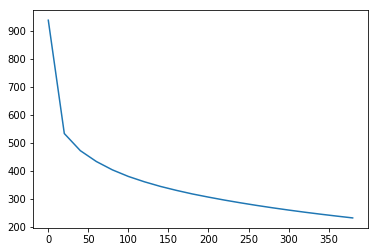

In [78]:
plt.plot(range(0, n*step, step), error)